In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# For importing example data
import sqlalchemy
import sqlalchemy_utils
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

In [4]:
# Define a database name
# Set your postgres username
dbname = "baseball"
username = "lacar"  # change this to your username

# Working with PostgreSQL in Python
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database=dbname, user=username)

# Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine("postgres://%s@localhost/%s" % (username, dbname))
print(engine.url)

postgres://lacar@localhost/baseball


[Writing math symbols in markdown](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html)

[quick reference](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference)

CSVs can be found here: https://github.com/JWarmenhoven/ISLR-python/tree/master/Notebooks/Data

# ISLR (Ch 8): Tree-Based Methods

- Applies to regression and classification
- Involves *stratifying* or *segmenting* the predictor space into a number of simple regions
- To make a prediction for a given observation, we typically use the mean or mode of the training observations in the region to which it belongs.
- The set of splitting rules used to segment the predictor space can be summarized in a tree
- Decision trees are simple and useful for interpretation, but on their own they're not great for prediction accuracy. But they perform better when multiple trees are used as in bagging, random forests, and boosting. These dramatically improve prediction at the expense of some loss in interpretation.

## The basics of decision trees

Regression and classification applications

### Regression trees

Use a baseball dataset, predicting a hitter's salary based on the number of years played and number of hits.

In [5]:
# Example data from R ISLR package
df_hitters = pda.read_csv('ISLR_data/Hitters.csv')
df_hitters.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.0,NaN


**Let's manually construct the decision tree!**
<br>
Plot the raw data and add the mean of each feature to the plot. Plot histograms of each feature too, to see if transformation is necessary.

In [6]:
mean_years = df_hitters['Years'].mean()
mean_hits = df_hitters['Hits'].mean()
print('Mean years: ', mean_years, ' and mean hits: ', mean_hits)

Mean years:  7.444099378881988  and mean hits:  101.0248447204969


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


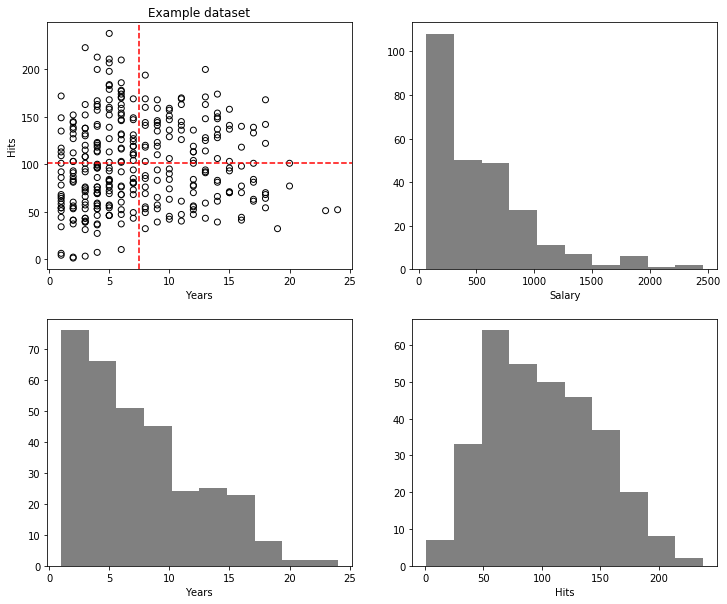

In [7]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10))
ax1.scatter(df_hitters['Years'], df_hitters['Hits'], facecolors='none', edgecolors='k')
ax1.set_xlabel('Years')
ax1.set_ylabel('Hits')
ax1.set_title('Example dataset')
ax1.axvline(mean_years, color='r', linestyle='dashed')
ax1.axhline(mean_hits, color='r', linestyle='dashed')

ax2.hist(df_hitters['Salary'], color='gray')
ax2.set_xlabel('Salary')

ax3.hist(df_hitters['Years'], color='gray')
ax3.set_xlabel('Years')

ax4.hist(df_hitters['Hits'], color='gray')
ax4.set_xlabel('Hits');

In [8]:
# Drop na and log transform salary
df_hitters = df_hitters.loc[df_hitters['Salary'].dropna().index, :].copy()
df_hitters['log_Salary'] = np.log(df_hitters['Salary'])
df_hitters.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,log_Salary
1,Alan Ashby,315,81,7,24,38,39,14,3449,835,...,414,375,N,W,632,43,10,475.0,N,6.163315
2,Alvin Davis,479,130,18,66,72,76,3,1624,457,...,266,263,A,W,880,82,14,480.0,A,6.173786
3,Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,838,354,N,E,200,11,3,500.0,N,6.214608
4,Andres Galarraga,321,87,10,39,42,30,2,396,101,...,46,33,N,E,805,40,4,91.0,NaN,4.510860
5,Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,336,194,A,W,282,421,25,750.0,A,6.620073


Text(0.5, 0, 'log_Salary')

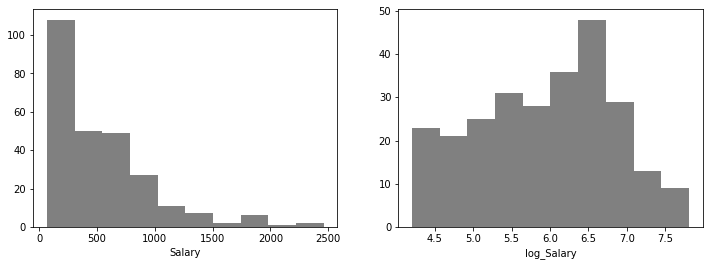

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.hist(df_hitters['Salary'], color='gray')
ax1.set_xlabel('Salary')

ax2.hist(df_hitters['log_Salary'], color='gray')
ax2.set_xlabel('log_Salary')


**Prediction via stratification of the feature space**

Roughly speaking, there are two steps to building a regression tree.

1. Divide the predictor space--that is, the set of possible values for $X_1, X_2, ...., X_p$ --into $J$ distinct and non-overlapping regions, $R_1, R_2, ..., R_J$.
2. For every observation that falls into the region $R_J$, we make the same prediction, which is simply the mean of the response values for the training observations in $R_J$.

In [10]:
# Let's first cut at years - at value of 4.5

yrs_split = 4.5

r1_left = df_hitters[df_hitters['Years'] < yrs_split].copy()
r1_right = df_hitters[df_hitters['Years'] > yrs_split].copy()

r1_left_mean_y = r1_left['log_Salary'].mean()
r1_right_mean_y = r1_right['log_Salary'].mean()

# Calculate RSS (residual sum of squares)
rss_left = sum((r1_left['log_Salary'] - r1_left_mean_y)**2)
rss_right = sum((r1_right['log_Salary'] - r1_right_mean_y)**2)

total_rss = rss_left + rss_right


In [11]:
# Find values of multiple split points for year
total_rss_list = list()

for yrs_split in range(1, 20):
    r1_left = df_hitters[df_hitters['Years'] < yrs_split].copy()
    r1_right = df_hitters[df_hitters['Years'] > yrs_split].copy()

    r1_left_mean_y = r1_left['log_Salary'].mean()
    r1_right_mean_y = r1_right['log_Salary'].mean()

    # Calculate RSS (residual sum of squares)
    rss_left = sum((r1_left['log_Salary'] - r1_left_mean_y)**2)
    rss_right = sum((r1_right['log_Salary'] - r1_right_mean_y)**2)

    total_rss = rss_left + rss_right
    total_rss_list.append(total_rss)

In [12]:
# Find values of multiple split points for hits
total_rss_list_hits = list()

for hits_split in range(1, 200, 10):
    r1_left = df_hitters[df_hitters['Hits'] < hits_split].copy()
    r1_right = df_hitters[df_hitters['Hits'] > hits_split].copy()

    r1_left_mean_y = r1_left['log_Salary'].mean()
    r1_right_mean_y = r1_right['log_Salary'].mean()

    # Calculate RSS (residual sum of squares)
    rss_left = sum((r1_left['log_Salary'] - r1_left_mean_y)**2)
    rss_right = sum((r1_right['log_Salary'] - r1_right_mean_y)**2)

    total_rss = rss_left + rss_right
    total_rss_list_hits.append(total_rss)


Lowest RSS value from doing split on years:  95.74770945978157
Lowest RSS value from doing split on hits:  162.52153775594377


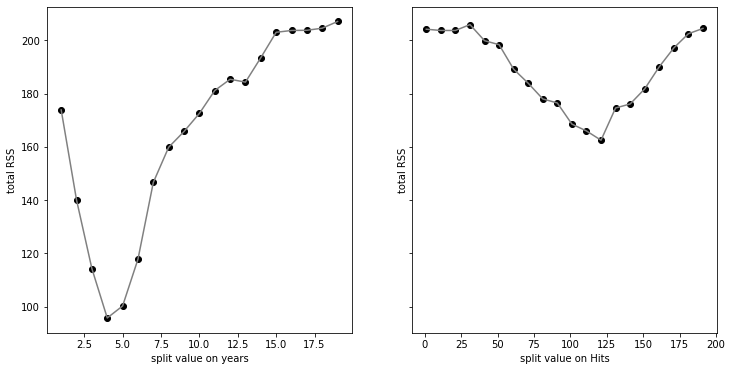

In [13]:
# Plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey=True)

ax1.scatter(range(1, 20), total_rss_list, color='black')
ax1.plot(range(1, 20), total_rss_list, color='gray')
ax1.set_xlabel('split value on years')
ax1.set_ylabel('total RSS');

ax2.scatter(range(1, 200, 10), total_rss_list_hits, color='black')
ax2.plot(range(1, 200, 10), total_rss_list_hits, color='gray')
ax2.set_xlabel('split value on Hits')
ax2.set_ylabel('total RSS');

print('Lowest RSS value from doing split on years: ', min(total_rss_list))
print('Lowest RSS value from doing split on hits: ', min(total_rss_list_hits))

**Recursive binary splitting** = top-down and greedy

- top-down: begins at the top of the tree
- greedy: takes the best split at that particular step, rather than looking ahead for a split that might be better in the future (splitting on years will give a lower error than splitting on hits at this first step)

(Can run sklearn to get the rest of the decision tree)

**Tree pruning**

A tree can have good performance in a training set but it is likely to overfit a test set if it is overly complex. However, you do not want to stop building a tree too soon since a worthless split early (small RSS reduction) could result in a very good split later (large RSS reduction). It is better to grow a large tree first, then prune later to obtain a smaller *subtree*. This can be done by selecting the subtree that leads to the lowest test eror rate.  It'd be cumbersome to generate a cross-validation error for every subtree, since that can be very large. Instead you can employ *cost complexity pruning* find a way to select a small set of subtrees for consideration

**Cost complexity pruning** = weakest link pruning. Analogous to regularization. Consider a sequence of trees indexed by a non-negative tuning parameter $\alpha$. Alpha controls a trade-off between the subtree's complexity and its fit to the training data. When alpha=0, the subtree $T = T_0$ where $T_0$ is the unpruned tree.

**Algorithm for building a regression tree**

1. Use recursive binary splitting to grow a large tree on the training data, stopping only when each terminal node has fewer than some minimum number of observations.
2. Apply cost complexity pruning to the large tree in order to obtain a sequence of best subtrees, as a function of alpha.
3. Use K-fold cross-validation to choose alpha.
    - Repeat steps 1 and 2 on all but the kth fold of the training data.
    - Evaluate the mean squared prediction error on the data in the left-out kth fold, as a function of alpha.
    - Average the results for each value of alpha, and pick alpha to minimize the average error.
4. Return the subtree from step 2 that corresponds to the chosen value of alpha.

### Classification trees

Similar to regression tree, except that it is used to predict a qualitative response rather than a quantitative one. For a classification tree, we predict that each observation belongs to the *most commonly occuring class* of training observations in the region to which it belongs. In interpreting the results of a classification tree, we are often interested not only in the class prediction corresponding to a particular terminal node region, but also in the *class proportions* among the training observations that fall into that region. The metrics used in classification trees for recursive binary splitting are the *Gini index* and *entropy*.

Gini index: a measure of total variance across the K classes.
$G = \sum_{k=1}^K \hat{p_{mk}}(1 - \hat{p_{mk}})$


Entropy: alternative but related
$D = -\sum_{k=1}^K \hat{p_{mk}}log\hat{p_{mk}}$

One can show that entropy will take on a value near zero if the $\hat{p_{mk}}$'s are all near zero or near one. Therefore, like the Gini index, the entropy will take on a small value if the *m*th node is pure.

### Trees versus linear models

## Bagging, random forests, boosting

### Bagging

**Bagging = bootstrap aggregation**

The bootstrap, introduced in Chapter  5, is an extremely powerful idea. It is used in many situations in which it is hard or even impossible to directly compute the standard deviation of a quantity of interest. We see here that the **bootstrap can be used in a completely different context, in order to improve statistical learning methods such as decision trees**.



The decision trees discussed in Section 8.1 suffer from high variance. This means that if we split the training data into two parts at random, and fit a decision tree to both halves, the results that we get could be quite different. In contrast, a procedure with low variance will yield similar results if applied repeatedly to distinct data sets; linear regression tends to have low variance, if the ratio of n to p is moderately large. Bootstrap aggregation, or bagging, is a general-purpose procedure for reducing the variance of a statistical learning method; we introduce it here because it is particularly useful and frequently used in the context of decision trees.

#### Self-directed exercise: What is meant by variance in this context?

- Why would a decision tree have high variance? It can get deep and overfit.
- Why would linear regression have low variance?
- To what metric is the variance prescribed? The "results". Are these the predictions at each x? Let's see.

https://datascience.stackexchange.com/questions/48166/why-can-decision-trees-have-a-high-amount-of-variance#:~:text=A%20model%20has%20high%20variance,outcome%20of%20a%20soccer%20game.

- error from sensitivity to small fluctuations in the training set


Recall that given a set of n independent observations $Z_1$, …, $Z_n$ , each with variance $\sigma^2$, the variance of the mean $\bar{Z}$ of the observations is given by $\sigma^2$∕n. In other words, averaging a set of observations reduces variance. Hence a natural way to reduce the variance and hence increase the prediction accuracy of a statistical learning method is to take many training sets from the population, build a separate prediction model using each training set, and average the resulting predictions. But it's not practical to have multiple training sets, so one way to go about this is to **bootstrap**, in other words, taking repeated samples from the (single) training data set.

In this approach we generate B different bootstrapped training data sets. We then train our method on the *b*th bootstrapped training set in order to get $\hat{f}^{*b}(x)$, and finally average all the predictions, to obtain

$\hat{f}^{*b}(x) = \frac{1}{B}\sum_{k=1}^B \hat{f}^{*b}(x)$

This is called bagging.

While bagging can improve predictions for many regression methods, it is particularly useful for decision trees. To apply bagging to regression trees, we simply construct B regression trees using B bootstrapped training sets, and average the resulting predictions. These trees are grown deep, and are not pruned. Hence **each individual tree has high variance, but low bias. Averaging these B trees reduces the variance.** Bagging has been demonstrated to give impressive improvements in accuracy by combining together hundreds or even thousands of trees into a single procedure.


#### Out-of-bag error estimation

## Insight QotD questions:

1. What do we mean by the variance and bias of a statistical learning method?

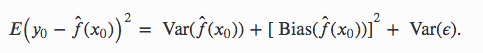

Left side of the equation is the test set mean squared error (assume a regression model in this example). (The last term is the irreducible error or the noise in the data.) 

- **What is meant by "variance" in this context?**
Variance refers to the amount by which f_hat would change if we estimated it using a different training data set. Since the training data are used to fit the statistical learning method, different training data sets will result in a different f_hat. But ideally the estimate for f should not vary too much between training sets. 
    
- **What does the "bias" in this context?**
Refers to the error that is introduced by approximating a real-life problem, which may be extremely complicated, by a much simpler model (it underfits).

- **Which model is prone to higher variance (or lower bias), a decision tree or linear regression?**
- If you change the training set a little bit, it would cause a bigger change in a decision tree model (hence, more variance) than in a linear regression model.

https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

https://datascience.stackexchange.com/questions/48166/why-can-decision-trees-have-a-high-amount-of-variance#:~:text=A%20model%20has%20high%20variance,outcome%20of%20a%20soccer%20game.



**Compare and contrast bagging and boosting, in the context of decision trees.**

**Both are forms of ensemble learning.**

**Where does the term “bagging” come from?**

**What is run in parallel versus sequentially?**

**What "problem" does each approach solve?**


Bagging in random forest

- bootstrap aggregation
- parallel
- can put second bag... choose from datapoints selected from first pass
- 1000 estimators, in RF.... 1000 decision trees
- can pick majority vote...
- bagging/bootstrapping
- in order to reduce variance, decision tree has a high variance 
    - variance of the mean
    - .... decision tree has high variance, it means has potential to overfit
    - it can go down one internal node - performs well on training and not as well on test

- RF reduces variance, but to overcome bias or low performance, use boosting

Boosting - look at Google

- sequential
- gets sample of data, trains it, then evaluates on other data

second set of data
- uses data points that weren't selected before and adds some randomness
- builds upon previous model
- uses knowledge from previous model

- some points get bigger


https://link.springer.com/chapter/10.1007/978-1-4614-7138-7_8#Sec9





2. Explain the random forest algorithm.
    - Like bagging, build a number of decision trees on bootstrapped training samples. But when building trees, a random subset of features is chosen as split candidates from the full set of features.
    - What if you DON'T do this?
    
    - If things are very correlated, then averaging many things, make it prone to high varaince (sensitivity to changes in the training set).
    

# SKlearn and Medium article for classification

https://scikit-learn.org/stable/modules/tree.html

Info on iris dataset
<br>
https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

Great explanations
<br>
https://victorzhou.com/blog/intro-to-random-forests/
<br>
https://victorzhou.com/blog/gini-impurity/#recap
<br>
https://victorzhou.com/blog/information-gain/

In [29]:
from sklearn import datasets
from sklearn import tree

In [42]:
iris = datasets.load_iris()
X = iris.data[:, ::2]
y = iris.target

In [53]:
iris.feature_names[0:2]

['sepal length (cm)', 'sepal width (cm)']

In [18]:
#X, y = load_iris(return_X_y=True)

In [43]:
X

array([[5.1, 1.4],
       [4.9, 1.4],
       [4.7, 1.3],
       [4.6, 1.5],
       [5. , 1.4],
       [5.4, 1.7],
       [4.6, 1.4],
       [5. , 1.5],
       [4.4, 1.4],
       [4.9, 1.5],
       [5.4, 1.5],
       [4.8, 1.6],
       [4.8, 1.4],
       [4.3, 1.1],
       [5.8, 1.2],
       [5.7, 1.5],
       [5.4, 1.3],
       [5.1, 1.4],
       [5.7, 1.7],
       [5.1, 1.5],
       [5.4, 1.7],
       [5.1, 1.5],
       [4.6, 1. ],
       [5.1, 1.7],
       [4.8, 1.9],
       [5. , 1.6],
       [5. , 1.6],
       [5.2, 1.5],
       [5.2, 1.4],
       [4.7, 1.6],
       [4.8, 1.6],
       [5.4, 1.5],
       [5.2, 1.5],
       [5.5, 1.4],
       [4.9, 1.5],
       [5. , 1.2],
       [5.5, 1.3],
       [4.9, 1.4],
       [4.4, 1.3],
       [5.1, 1.5],
       [5. , 1.3],
       [4.5, 1.3],
       [4.4, 1.3],
       [5. , 1.6],
       [5.1, 1.9],
       [4.8, 1.4],
       [5.1, 1.6],
       [4.6, 1.4],
       [5.3, 1.5],
       [5. , 1.4],
       [7. , 4.7],
       [6.4, 4.5],
       [6.9,

In [44]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

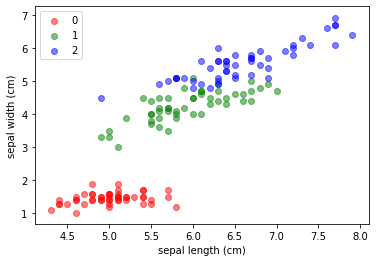

In [66]:
f, ax1 = plt.subplots()
color_list = ['red', 'green', 'blue']
for i in range(3):
    row_bool = y==i
    ax1.scatter(X[row_bool, 0], X[row_bool, 1], color=color_list[i], alpha=0.5, label=i)
ax1.set_xlabel(iris.feature_names[0])
ax1.set_ylabel(iris.feature_names[1])
ax1.legend();

In [57]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

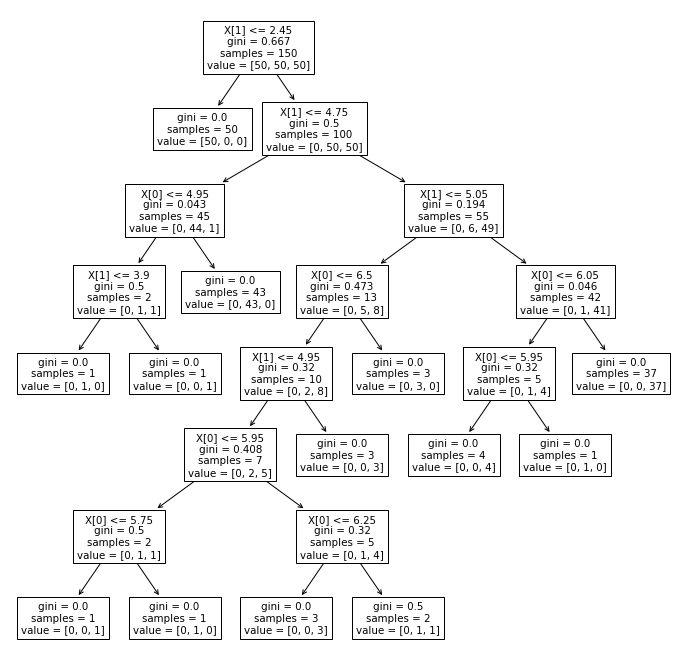

In [58]:
f, ax1 = plt.subplots(figsize=(12,12))
tree.plot_tree(clf.fit(X,y), ax=ax1);

In [51]:
print(clf.feature_importances_)
print(iris.feature_names[0:2])

[0.06786793 0.93213207]
['sepal length (cm)', 'sepal width (cm)']


In [52]:
sum(clf.feature_importances_)

1.0

# [bottom of notebook]